# Forecasting
t<sub>0</sub> corresponds to the time at which the forecast is made (12:00 CET) for EPEX SPOT day-ahead auction.<br>

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from utils import tools, preprocessing, models, eval, plotting

In [2]:
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Tensorflow version:', tf.__version__)

Pandas version: 2.2.3
Numpy version: 1.26.4
Tensorflow version: 2.17.1


In [3]:
config = tools.load_config('config.yaml')

In [4]:
# paths
data = 'pvod'
key = 'station01.csv'

# model params
model_name = 'tft'
output_dim = 48 # in hours
batch_size = 16
learning_rate = 0.0004
epochs = 20
n_layers = 2
filters = 64
kernel_size = 2
units = 256
make_callbacks = False

# data params
freq = '1h'
lookback = 48 # in hours
horizon = 48 # in hours
# data split params
t_0 = 12 # epex spot auction time (12:00 CET)
scale_y = False
lag_in_col = False

# more params
evaluate_on_all_test_data = True
study_name = None#f'fl_d_{data}_m-{model_name}_out-{output_dim}_freq-{freq}'

In [5]:
# config related
config['data']['freq'] = freq
config['model']['name'] = model_name
config['model']['output_dim'] = output_dim
config['model']['lookback'] = lookback
config['model']['horizon'] = horizon
config = tools.handle_freq(config=config)
freq = config['data']['freq']
output_dim = config['model']['output_dim']
config['model']['lookback'] = lookback
config['model']['horizon'] = horizon

In [6]:
# read data
#df = preprocessing.preprocess_1b_trina(path=path,
#                                       freq=freq)
known, observed, static = preprocessing.get_features(data=data)
dfs = preprocessing.get_data(data=data, data_dir='../../Data', freq=freq)
df = dfs[key]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8352 entries, 2018-06-30 16:00:00 to 2019-06-13 15:00:00
Freq: h
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   nwp_globalirrad    8352 non-null   float64
 1   nwp_directirrad    8352 non-null   float64
 2   nwp_temperature    8352 non-null   float64
 3   nwp_humidity       8352 non-null   float64
 4   nwp_windspeed      8352 non-null   float64
 5   nwp_winddirection  8352 non-null   float64
 6   nwp_pressure       8352 non-null   float64
 7   lmd_totalirrad     8352 non-null   float64
 8   lmd_diffuseirrad   8352 non-null   float64
 9   lmd_temperature    8352 non-null   float64
 10  lmd_pressure       8352 non-null   float64
 11  lmd_winddirection  8352 non-null   float64
 12  lmd_windspeed      8352 non-null   float64
 13  power              8352 non-null   float64
dtypes: float64(14)
memory usage: 978.8 KB


In [8]:
prepared_data, _ = preprocessing.pipeline(data=df,
                                           config=config,
                                           known_cols=known,
                                           observed_cols=observed,
                                           static_cols=static)
X_train, y_train = prepared_data['X_train'], prepared_data['y_train'],
X_test, y_test = prepared_data['X_test'], prepared_data['y_test']
index_train = prepared_data['index_train']
index_test = prepared_data['index_test']
scaler_y = prepared_data['scalers']['y']
#print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Training data range: 2018-06-30 16:00:00 to 2019-02-28 23:00:00 (5840 rows)
Test data range:     2019-03-01 00:00:00 to 2019-06-13 15:00:00 (2512 rows)
No static data provided.
No static data provided.

Shapes of generated arrays (Train):
X_static_train:   (0,)
X_known_train:    (5745, 96, 5)
X_observed_train: (5745, 48, 7)
y_train:          (5745, 48)


In [ ]:
if study_name:
    hyperparameters = tools.load_hyperparams(study_name=study_name,
                                             config=config)
else:
    hyperparameters = {}
    hyperparameters['batch_size'] = batch_size
    hyperparameters['epochs'] = epochs
    hyperparameters['output_dim'] = output_dim
    hyperparameters['n_layers'] = n_layers
    hyperparameters['filters'] = filters
    hyperparameters['kernel_size'] = kernel_size
    hyperparameters['lr'] = learning_rate
    hyperparameters['units'] = units
    hyperparameters['lookback'] = lookback
    hyperparameters['horizon'] = horizon
    hyperparameters['n_heads'] = 2
    hyperparameters['hidden_dim'] = 8
    hyperparameters['dropout'] = 0.2
    hyperparameters['shuffle'] = False


config['model']['name'] = model_name

config['model']['feature_dim'] = tools.get_feature_dim(X_train)
model = models.get_model(config=config,
                         hyperparameters=hyperparameters)

In [10]:
model.summary()

Model: "TemporalFusionTransformer_VSN_Masked_OptStatic"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ known_input         │ (None, 96, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ observed_input      │ (None, 48, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 48, 5)     │          0 │ known_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ observed_vsn_weigh… │ (None, 48, 7)     │         56 │ observed_input[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ known_encoder_vsn_… │ (None, 48, 5)     │         30 │ get_item[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ observed_vsn_weigh… │ (None, 48, 7)     │          0 │ observed_vsn_wei… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ known_encoder_vsn_… │ (None, 48, 5)     │          0 │ known_encoder_vs… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 48, 5)     │          0 │ known_input[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ observed_vsn_weigh… │ (None, 48, 7)     │         56 │ observed_vsn_wei… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ observed_vsn_weigh… │ (None, 48, 7)     │         56 │ observed_input[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ known_encoder_vsn_… │ (None, 48, 5)     │         30 │ known_encoder_vs… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ known_encoder_vsn_… │ (None, 48, 5)     │         30 │ get_item[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ known_decoder_vsn_… │ (None, 48, 5)     │         30 │ get_item_1[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 48, 7)     │          0 │ observed_vsn_wei… │
│                     │                   │            │ observed_vsn_wei… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 48, 5)     │          0 │ known_encoder_vs… │
│ (Multiply)          │                   │            │ known_encoder_vs… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ known_decoder_vsn_… │ (None, 48, 5)     │          0 │ known_decoder_vs… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 48, 7)     │          0 │ observed_input[0… │
│                     │                   │            │ multiply[0][0]  

 Total params: 2,447 (9.56 KB)

 Trainable params: 2,447 (9.56 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
if make_callbacks:
    callbacks = [keras.callbacks.ModelCheckpoint('models/best.keras', save_best_only=True)]

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = hyperparameters['batch_size'],
    epochs = hyperparameters['epochs'],
    verbose = 'auto',
    callbacks = callbacks if make_callbacks else None,
    validation_data=(X_test, y_test),
    shuffle = hyperparameters['shuffle']
)
if make_callbacks:
    model = keras.models.load_model('models/best.keras')
best_epoch = np.argmin(history.history['val_loss']) + 1

Epoch 1/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 0.1370 - mae: 0.2849 - rmse: 0.3635 - val_loss: 0.0392 - val_mae: 0.1533 - val_rmse: 0.1979
Epoch 2/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0468 - mae: 0.1657 - rmse: 0.2151 - val_loss: 0.0242 - val_mae: 0.1157 - val_rmse: 0.1557
Epoch 3/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0341 - mae: 0.1386 - rmse: 0.1840 - val_loss: 0.0183 - val_mae: 0.0986 - val_rmse: 0.1352
Epoch 4/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0279 - mae: 0.1232 - rmse: 0.1666 - val_loss: 0.0156 - val_mae: 0.0900 - val_rmse: 0.1247
Epoch 5/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0241 - mae: 0.1131 - rmse: 0.1550 - val_loss: 0.0139 - val_mae: 0.0850 - val_rmse: 0.1180
Epoch 6/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0217 - mae: 0.1059 - rmse: 0.1469 - val_loss: 0.0129 - val_mae: 0.0814 - val_rmse: 0.1136
Epoch 7/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0197 - mae: 0.0998

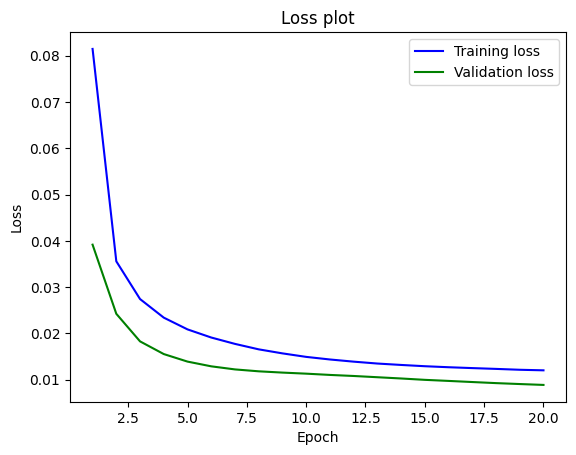

In [12]:
plotting.plot_training(history=history,
                       validation=True,
                       save_name=None)

In [13]:
y_true, y_pred = tools.get_y(X_test=X_test,
                             y_test=y_test,
                             scaler_y=scaler_y,
                             model=model)
df_pred = tools.y_to_df(y=y_pred,
                        output_dim=output_dim,
                        horizon=horizon,
                        index_test=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)
df_true = tools.y_to_df(y=y_true,
                        output_dim=output_dim,
                        horizon=horizon,
                        index_test=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)

y_pers = eval.persistence(y=df['power'],
                    horizon=horizon,
                    from_date=str(index_test[0].date()))
y_pers = preprocessing.make_windows(data=y_pers,
                                    seq_len=y_pred.shape[-1])
df_pers = tools.y_to_df(y=y_pers,
                    output_dim=output_dim,
                    horizon=horizon,
                    index_test=index_test,
                    t_0=None if evaluate_on_all_test_data else t_0)

pers = {}
pers['Persistence'] = df_pers

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


In [14]:
results = eval.evaluate_models(pred=df_pred,
                               true=df_true,
                               persistence=pers,
                               main_model_name=model_name)

In [15]:
results

,R^2,RMSE,MAE,Skill
Models,,,,
tft,0.908505,0.092785,0.049733,0.411282
Persistence,0.736013,0.157604,0.074370,0.000000


R^2: 0.9588829822390795
RMSE: 0.0784954561253272
MAE: 0.049718753171029195


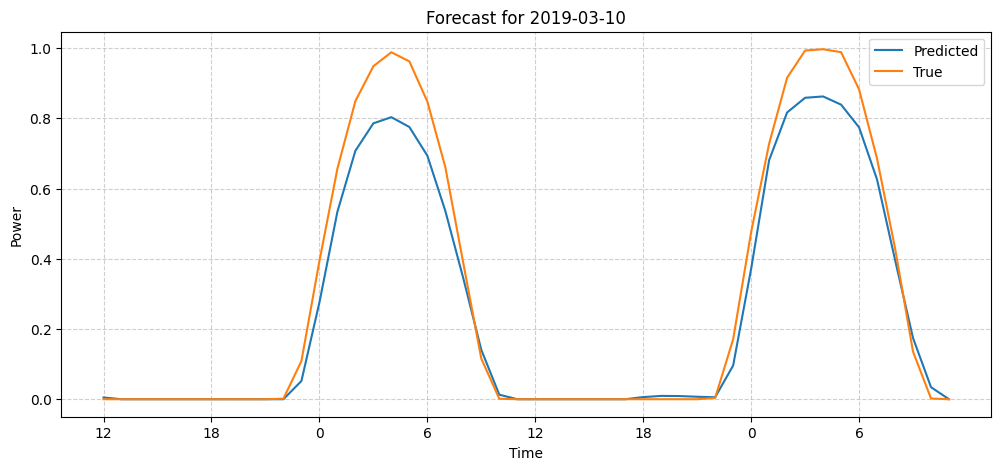

In [20]:
#date = '2018-06-06'
date = plotting.random_date(start_date=str(index_test[0].date()),
                            end_date=str(df.index[-1].date()))

plotting.plot_forecast(pred=df_pred,
                       true=df_true,
                       date=date,
                       horizon=horizon,
                       t_0=t_0,
                       figsize=(12,5),
                       print_metric=True,
                       grid=True)

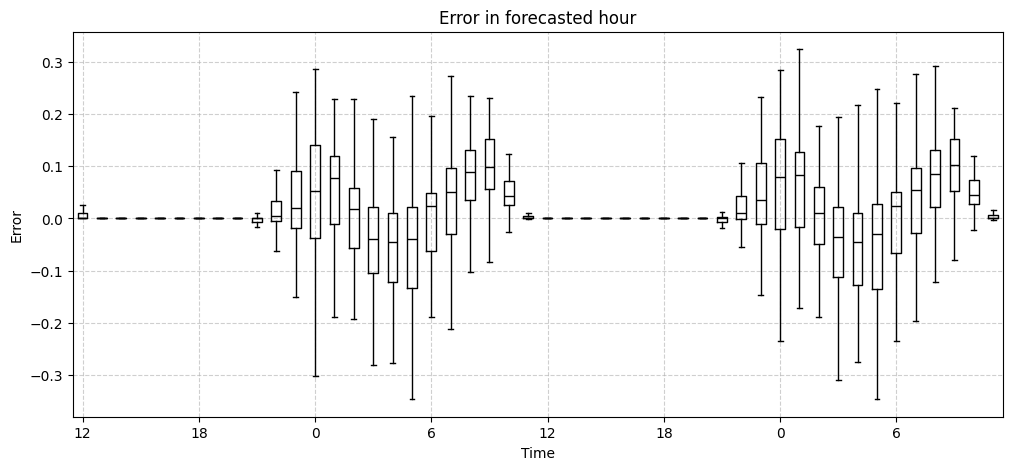

In [21]:
plotting.plot_boxplots(pred=df_pred,
                       true=df_true,
                       t_0=t_0,
                       horizon=horizon,
                       figsize=(12,5),
                       showfliers=False,
                       grid=True)

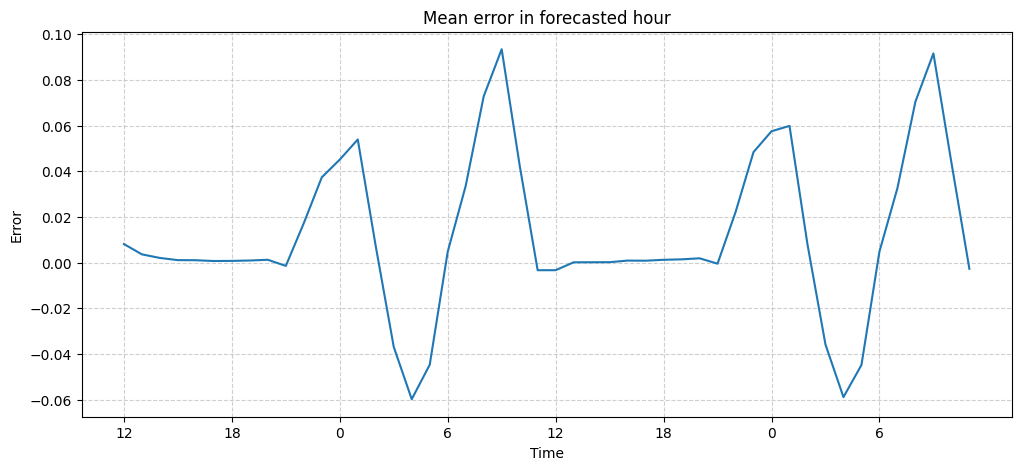

In [18]:
plotting.plot_error(pred=df_pred,
                    true=df_true,
                    t_0=t_0,
                    horizon=horizon,
                    figsize=(12,5),
                    grid=True)

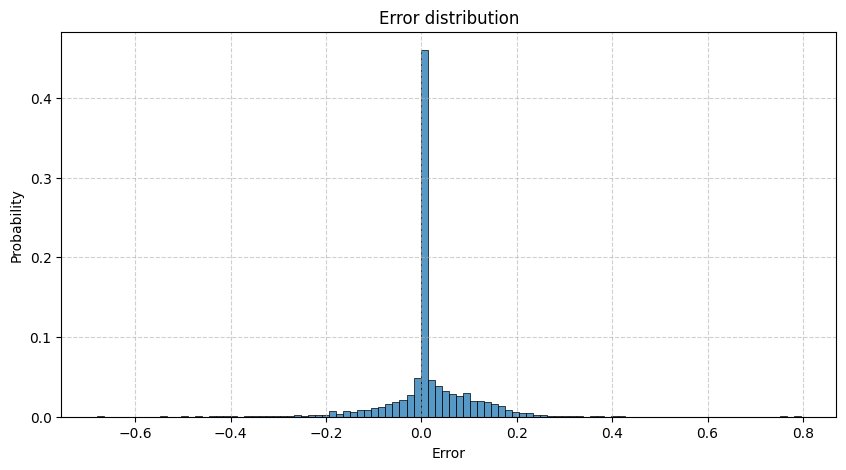

In [19]:
plotting.plot_error_distribution(pred=df_pred,
                                 true=df_true,
                                 figsize=(10,5),
                                 bins=100,
                                 t_0=t_0,
                                 grid=True)